# Inspiration for HyperUnmixing

### The project is inspired from this paper : [Kong *et al.*](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b01003)

![title of paper](../data/paper_title.png)

### What does the paper show?

This study used Photo-induced Atomic Force Microscopy (Pi-AFM) images to construct hyperspectral images where each pixel has a depth of 1128 wavelengths. How are these images generated?

The spot where the AFM probe comes in contact is illuminated by varying wavelengths of IR radiation as shown in the image below. The AFM probe notes the signal of the sample at different vibrational modes triggered by varying the wavelength of illumination.

![Pi-AFM microscopy](../data/PiAFM.png)



From the data obtained from Pi-AFM,

![hyperspectral_image.png](../data/hyperspectral_image.png)

### In the paper, a hyperspectral image like this obtained from Pi-AFM is used to predict a conduction map obtained from conductive probe microscopy, using a linear regression on the principle components.

![worflow](../data/workflow.png)

### This gave an idea to the "HyperUnmixing" project in which we explored tools that can 'unmix' and analyze hyperspectral images like these.

## Principal Component Analysis (PCA):

A nice small tutorial for PCA is available [here](https://pdfs.semanticscholar.org/a99e/0f8f58af7a91e26c1eda54e0cca3e3e03df3.pdf?_ga=2.145751990.38709335.1591063750-1382180718.1591063750).

In PCA, from the data spread, we try to extract the significant directions along which the variance is maximum. These directions would be the linear combinations of the original directions or features and are called principle components.

![PCA_intro1.png](../data/PCA_intro1.png)

The number of principle components to take depends on the distribution of total variance among the principle components. In the example above, one PC is sufficient.

### Initial Steps in PCA:
1. The main assumption for PCA is that all data follows a gaussian distribution around a mean point. So, we shift the origin to this mean point.
2. Then we look for directions along which the variance would be minimum.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
import sys

IMG_PATH = 'C:/Users/Preetham/Desktop/CHEME599/DPPDTT-PS.npy'
BASE_DPPDTT = 'C:/Users/Preetham/Desktop/CHEME599/dppdtt_ground_truth.npy'
BASE_PS = 'C:/Users/Preetham/Desktop/CHEME599/ps_ground_truth.npy'

After importing all the necessary modules, need to add the utilites folder to the sys.path

In [20]:
sys.path.append("../HyperUnmixing")
from pca_util import get_PC, plot_PCs, make_PC_images
from normalization import normalization
from img_util import avg_spectra
from processing import mask_im

Load the image and normalize it. Change the IMG_PATH to the location where image is stored.

In [3]:
im = np.load(IMG_PATH)
im = normalization(im[:100,:100,:])
im.shape

(100, 100, 1128)

Each pixel in the image has a depth of 1128 layers, that is each pixel is a spectrum as shown below.

Text(0.5, 1.0, 'Depth of the pixel at (50,50)')

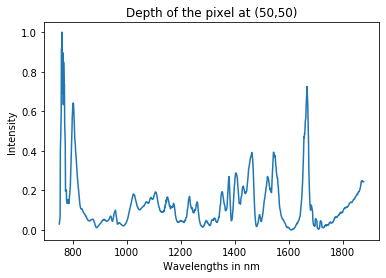

In [4]:
plt.plot(750 + np.arange(im.shape[2]), im[50,50,:])
plt.xlabel('Wavelengths in nm')
plt.ylabel('Intensity')
plt.title("Depth of the pixel at (50,50)")

`get_PC` function from the pca_util file in HyperUnmixing package can be used to do Principle Component Analysis on the image. The function considers each pixel independent, and takes the 1128 wavelengths in the depth of each pixel as features. PCA is done on these to get the their loading scores (or coefficients) in each PC.

In [5]:
#Get principle components
(loading_scores, scree_values) = get_PC(im)

#Loading the ground truths
dppdtt = np.load(BASE_DPPDTT)
dppdtt = dppdtt/np.max(dppdtt)

ps = np.load(BASE_PS)
ps = ps/np.max(ps)

#Features or depth of each pixel
feat_arr = np.arange(750, 750+im.shape[2], 1)

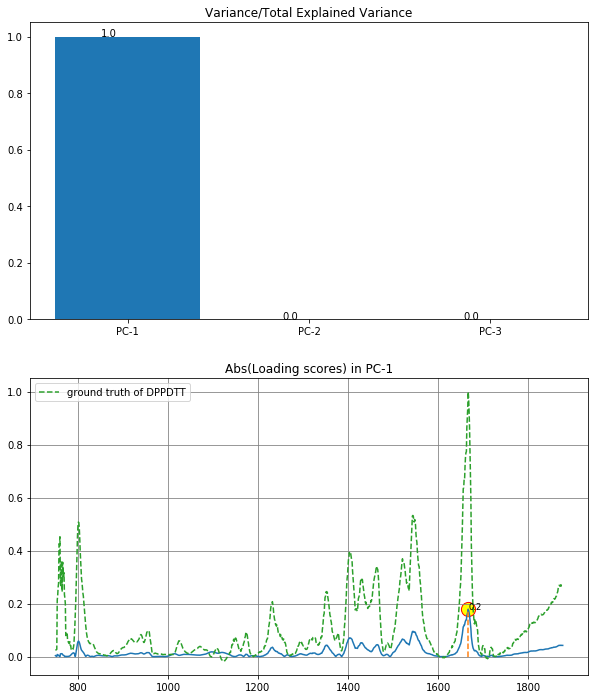

In [6]:
#PLOTTING PC-1
fig, ax = plt.subplots(nrows=2, figsize = (10,12))
ax = plot_PCs(ax, loading_scores, scree_values, top_n=3, PC_n=1, top_load_n=1)
ax[1].plot(feat_arr, dppdtt, label = 'ground truth of DPPDTT', linestyle='dashed')
ax[1].legend(fontsize=14)

Once the loading scores are obtained, just PC-1 and PC-2 alone can be used to represent the entire hyperspectral image.
If we compare these with the pure DPPDT and pure PSS plots,




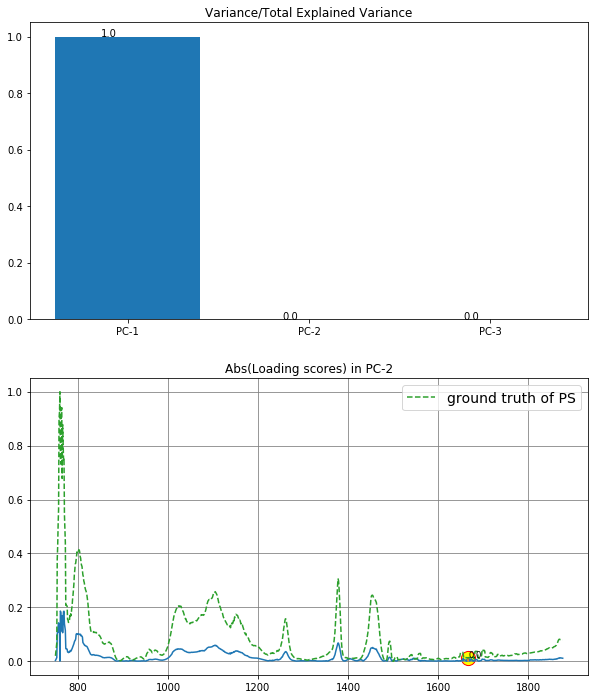

In [41]:
#PLOTTING PC-2
fig, ax = plt.subplots(nrows=2, figsize = (10,12))
ax = plot_PCs(ax, loading_scores, scree_values, top_n=3, PC_n=2, top_load_n=1)
ax[1].plot(feat_arr, ps, label = 'ground truth of PS', linestyle='dashed')
ax[1].legend(fontsize=14)

## How can we use PCA to get the fraction of polymer present?

## Dimentionality reduction of image depth from 1128 to 2


Using the linear combination of PC coefficients and the pixel spectra, we can decrease the dimensions to 2.

In [13]:
new_im = make_PC_images(im, loading_scores, PC_num=[1, 2])

Text(0.5, 1.0, 'PC-2 image corresponding to PS')

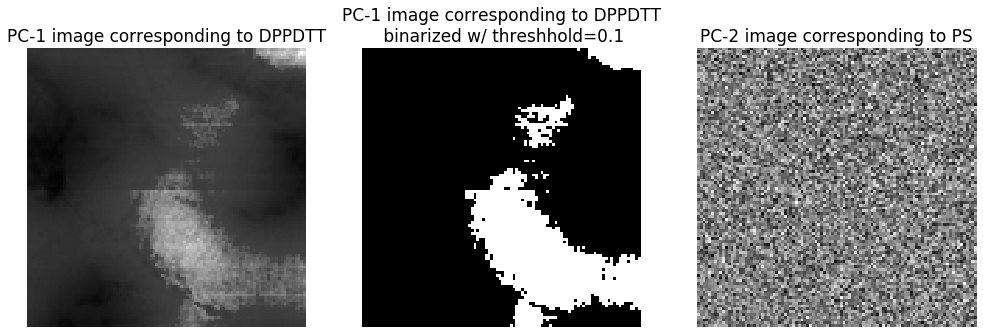

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(17,8))

ax[0].imshow(new_im[:,:,0], cmap='gray')
ax[0].axis('off')
ax[0].set_title("PC-1 image corresponding to DPPDTT", fontsize=17)

#Binarizing the DPPDT image
thresh = 0.1
binary_im = mask_im(new_im[:,:,0], thresh)
ax[1].imshow(binary_im, cmap='gray')
ax[1].axis('off')
ax[1].set_title("PC-1 image corresponding to DPPDTT\n binarized w/ threshhold={}".format(thresh), fontsize=17)

ax[2].imshow(new_im[:,:,1], cmap='gray')
ax[2].axis('off')
ax[2].set_title("PC-2 image corresponding to PS", fontsize=17)

## Major Drawback of PCA:

### As we see above, PC-2 fails to highlight PS rich regions. This is because, PCA assumes a normal distribution, i.e, assumes that data is centered about a single mean. So, here, it assumes that data is scattered about DPPDTT spectra because this component is dominating.

### So, we explored other factorizing or dimensionality-reducing methods to mitigate this. NMF was our next attempt.